In [1]:
from cassandra.cluster import Cluster
import station_pb2_grpc
import station_pb2
import pandas as pd
import sys
import os
import subprocess
import grpc
from datetime import date

from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType,StringType
from pyspark.sql.functions import udf
from pyspark.sql.functions import corr
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

In [2]:
cluster = Cluster(['p6_db_2', 'p6_db_1', 'p6_db_3'])
session = cluster.connect()

In [3]:
spark = (SparkSession.builder
         .appName("cassandra-connector")
         .config("spark.driver.allowMultipleContexts", "true")
         .config("spark.jars.packages", "com.datastax.spark:spark-cassandra-connector_2.12:3.2.0")
         .config("spark.sql.extensions", "com.datastax.spark.connector.CassandraSparkExtensions")
         .config("spark.cassandra.connection.host", "p6_db_3,p6_db_2,p6_db_1")  # Cassandra nodes
         .config("spark.cassandra.connection.port", "9042")  # Cassandra port
         .getOrCreate())

:: loading settings :: url = jar:file:/usr/local/lib/python3.10/dist-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
com.datastax.spark#spark-cassandra-connector_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-7e4bcd19-b194-4dac-a085-f6c320050bb7;1.0
	confs: [default]
	found com.datastax.spark#spark-cassandra-connector_2.12;3.2.0 in central
	found com.datastax.spark#spark-cassandra-connector-driver_2.12;3.2.0 in central


	found com.datastax.oss#java-driver-core-shaded;4.13.0 in central
	found com.datastax.oss#native-protocol;1.5.0 in central
	found com.datastax.oss#java-driver-shaded-guava;25.1-jre-graal-sub-1 in central
	found com.typesafe#config;1.4.1 in central
	found org.slf4j#slf4j-api;1.7.26 in central
	found io.dropwizard.metrics#metrics-core;4.1.18 in central
	found org.hdrhistogram#HdrHistogram;2.1.12 in central
	found org.reactivestreams#reactive-streams;1.0.3 in central
	found com.github.stephenc.jcip#jcip-annotations;1.0-1 in central
	found com.github.spotbugs#spotbugs-annotations;3.1.12 in central


	found com.google.code.findbugs#jsr305;3.0.2 in central
	found com.datastax.oss#java-driver-mapper-runtime;4.13.0 in central
	found com.datastax.oss#java-driver-query-builder;4.13.0 in central
	found org.apache.commons#commons-lang3;3.10 in central
	found com.thoughtworks.paranamer#paranamer;2.8 in central
	found org.scala-lang#scala-reflect;2.12.11 in central
:: resolution report :: resolve 561ms :: artifacts dl 20ms
	:: modules in use:
	com.datastax.oss#java-driver-core-shaded;4.13.0 from central in [default]
	com.datastax.oss#java-driver-mapper-runtime;4.13.0 from central in [default]
	com.datastax.oss#java-driver-query-builder;4.13.0 from central in [default]
	com.datastax.oss#java-driver-shaded-guava;25.1-jre-graal-sub-1 from central in [default]
	com.datastax.oss#native-protocol;1.5.0 from central in [default]
	com.datastax.spark#spark-cassandra-connector-driver_2.12;3.2.0 from central in [default]
	com.datastax.spark#spark-cassandra-connector_2.12;3.2.0 from central in [default]

23/09/05 22:57:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


## Part 1

In [4]:
def setup_cassandra_table():
    # TODO: Q1
    session.execute("DROP KEYSPACE IF EXISTS weather;") # Ensure to drop the keyspace

    # Create keyspace
    session.execute("""CREATE keyspace weather
    WITH REPLICATION = { 
    'class' : 'SimpleStrategy', 
    'replication_factor' : 3 
    };""")

    # Create type
    session.execute(""" CREATE type weather.station_record (
        tmin int,
        tmax int                
    );""")

    # Create table
    session.execute(""" CREATE TABLE weather.stations (
        id text,
        name text STATIC,
        date date,
        record FROZEN<weather.station_record>,
        PRIMARY KEY (id, date)              
    ) WITH CLUSTERING ORDER BY (date ASC); """)

In [5]:
# Q1 Ans
setup_cassandra_table()
print(session.execute("describe keyspace weather").one().create_statement)
print(session.execute("describe type weather.station_record").one().create_statement)
print(session.execute("describe table weather.stations").one().create_statement)

CREATE KEYSPACE weather WITH replication = {'class': 'SimpleStrategy', 'replication_factor': '3'}  AND durable_writes = true;
CREATE TYPE weather.station_record (
    tmin int,
    tmax int
);
CREATE TABLE weather.stations (
    id text,
    date date,
    name text static,
    record frozen<station_record>,
    PRIMARY KEY (id, date)
) WITH CLUSTERING ORDER BY (date ASC)
    AND additional_write_policy = '99p'
    AND bloom_filter_fp_chance = 0.01
    AND caching = {'keys': 'ALL', 'rows_per_partition': 'NONE'}
    AND cdc = false
    AND comment = ''
    AND compaction = {'class': 'org.apache.cassandra.db.compaction.SizeTieredCompactionStrategy', 'max_threshold': '32', 'min_threshold': '4'}
    AND compression = {'chunk_length_in_kb': '16', 'class': 'org.apache.cassandra.io.compress.LZ4Compressor'}
    AND crc_check_chance = 1.0
    AND default_time_to_live = 0
    AND extensions = {}
    AND gc_grace_seconds = 864000
    AND max_index_interval = 2048
    AND memtable_flush_period_in_

### Adding metadata to table

In [6]:
table = spark.read.option("header", True).csv("/datasets/stations_metadata.csv")
table.printSchema()

root
 |-- ID: string (nullable = true)
 |-- LATITUDE: string (nullable = true)
 |-- LONGITUDE: string (nullable = true)
 |-- ELEVATION: string (nullable = true)
 |-- STATE: string (nullable = true)
 |-- NAME: string (nullable = true)
 |-- GSN FLAG: string (nullable = true)
 |-- HCN/CRN FLAG: string (nullable = true)
 |-- WMO ID: string (nullable = true)



In [7]:
# TODO: Code to insert metadata into weather.stations
wisconsin_data = table.filter(table.STATE == "WI").toPandas()
query = "INSERT INTO weather.stations(id, name) VALUES (?, ?)"
prepared = session.prepare(query)
for index, row in wisconsin_data.iterrows():
    session.execute(prepared, (row["ID"], row["NAME"]) )

In [8]:
# Metadata insert verify
result = session.execute("SELECT COUNT(*) FROM weather.stations")
print(result.one()[0])

1313


In [9]:
def get_tokens(station_id):
    # TODO: Q2
    row = session.execute("SELECT token(id) FROM weather.stations WHERE id = %s", (station_id, ))
    row_token = row.one()[0]

    # Get all the vnode tokens
    result = subprocess.check_output(["nodetool", "ring"]).decode(sys.stdout.encoding)
    lines = result.splitlines()[3 : ]
    token_idx = lines.pop(0).index("Token")
    lines.pop(0)
    tokens = [line[token_idx : ].strip() for line in lines]

    # Get the v node token
    vnode_token = None
    if row_token <= int(tokens[0]):
        vnode_token = tokens[0]
    else:
        for i in range(0, len(tokens) - 1):
            # Make sure the tokens are valid
            if len(tokens[i]) == 0 or len(tokens[i + 1]) == 0:
                continue
            
            # Check if the row is in this range
            if row_token >= int(tokens[i]) and row_token <= int(tokens[i + 1]):
                vnode_token = tokens[i + 1]
                break
    
    return row_token, vnode_token

In [10]:
# Q2 Ans
row_token, vnode_token = get_tokens("USC00470273")
print("Row token:", row_token)
print("Vnode token:", vnode_token)

Row token: -9014250178872933741
Vnode token: -8771097503725394084


## Part 2

In [11]:
# TODO: Connect to the server
PORT_TO_USE = 5440
SERVER_ADDRESS = f"127.0.0.1:{PORT_TO_USE}"

channel = grpc.insecure_channel(SERVER_ADDRESS)
stub = station_pb2_grpc.StationStub(channel)

In [12]:
def simulate_sensor(sensor_id):
    # TODO: gRPC client simulation
    df = pd.read_csv("/datasets/station_temp_data.csv")
    df = df[df["station_id"] == sensor_id]

    record_by_date = {}
    for index, row in df.iterrows():
        # Make sure they are 2022 records
        record_date = str(row["date"]).strip()

        if record_date[ : 4] != "2022":
            continue
        
        # Make sure they are temperature records
        if row["type"] != "TMAX" and row["type"] != "TMIN":
            continue
        
        date_val = date(int(record_date[ : 4]), int(record_date[4 : 6]), int(record_date[6 : ]))
        if date_val not in record_by_date:
            record_by_date[date_val] = []
        record_by_date[date_val].append(int(row["value"]))
    
    count = 0
    for curr_date in record_by_date:
        date_temps = record_by_date[curr_date]
        if len(date_temps) >= 2:
            response = stub.RecordTemps(station_pb2.RecordTempsRequest(station = sensor_id, date = str(curr_date), tmin = min(date_temps), tmax = max(date_temps)))
            if len(response.error) > 0:
                count += 1
    return count

In [13]:
# gRPC client runner
for station in ["USW00014837", "USR0000WDDG", "USW00014898", "USW00014839"]:
    num_failed = simulate_sensor(station)
    if num_failed > 0:
        print("Failed to write all data for", station)
        break
    
    r = stub.StationMax(station_pb2.StationMaxRequest(station=station))
    if r.error:
        print(f"error {r.error} in getting max temp of {station}")
    else:
        print(f"max temp for {station} is {r.tmax}")

Failed to write all data for USW00014837


## Part 3

In [14]:
cassandra_df = spark.read \
    .format("org.apache.spark.sql.cassandra") \
    .options(table="stations", keyspace="weather") \
    .load()

23/09/05 22:58:12 ERROR CassandraConnectorConf: Unknown host 'p6_db_3'
java.net.UnknownHostException: p6_db_3: Temporary failure in name resolution
	at java.net.Inet4AddressImpl.lookupAllHostAddr(Native Method)
	at java.net.InetAddress$2.lookupAllHostAddr(InetAddress.java:867)
	at java.net.InetAddress.getAddressesFromNameService(InetAddress.java:1302)
	at java.net.InetAddress$NameServiceAddresses.get(InetAddress.java:815)
	at java.net.InetAddress.getAllByName0(InetAddress.java:1291)
	at java.net.InetAddress.getAllByName(InetAddress.java:1144)
	at java.net.InetAddress.getAllByName(InetAddress.java:1065)
	at java.net.InetAddress.getByName(InetAddress.java:1015)
	at com.datastax.spark.connector.cql.CassandraConnectorConf$.maybeResolveHostAndPort(CassandraConnectorConf.scala:346)
	at com.datastax.spark.connector.cql.CassandraConnectorConf$.$anonfun$getIpBasedContactInfoFromSparkConf$1(CassandraConnectorConf.scala:379)
	at scala.collection.TraversableLike.$anonfun$flatMap$1(TraversableLike.

23/09/05 22:58:18 WARN ChannelPool: [s0|/192.168.80.2:9042]  Error while opening new channel (ConnectionInitException: [s0|connecting...] Protocol initialization request, step 1 (STARTUP {CQL_VERSION=3.0.0, DRIVER_NAME=DataStax Java driver for Apache Cassandra(R), DRIVER_VERSION=4.13.0, CLIENT_ID=c83cb587-5ea5-46a1-8b90-62af50fac197, APPLICATION_NAME=Spark-Cassandra-Connector-local-1693954657898}): failed to send request (java.nio.channels.NotYetConnectedException))


23/09/05 22:58:19 ERROR CassandraConnectorConf: Unknown host 'p6_db_3'
java.net.UnknownHostException: p6_db_3
	at java.net.InetAddress$CachedAddresses.get(InetAddress.java:764)
	at java.net.InetAddress.getAllByName0(InetAddress.java:1291)
	at java.net.InetAddress.getAllByName(InetAddress.java:1144)
	at java.net.InetAddress.getAllByName(InetAddress.java:1065)
	at java.net.InetAddress.getByName(InetAddress.java:1015)
	at com.datastax.spark.connector.cql.CassandraConnectorConf$.maybeResolveHostAndPort(CassandraConnectorConf.scala:346)
	at com.datastax.spark.connector.cql.CassandraConnectorConf$.$anonfun$getIpBasedContactInfoFromSparkConf$1(CassandraConnectorConf.scala:379)
	at scala.collection.TraversableLike.$anonfun$flatMap$1(TraversableLike.scala:293)
	at scala.collection.immutable.Set$Set3.foreach(Set.scala:233)
	at scala.collection.TraversableLike.flatMap(TraversableLike.scala:293)
	at scala.collection.TraversableLike.flatMap$(TraversableLike.scala:290)
	at scala.collection.AbstractT

In [15]:
def cel_to_far_converter(temp):
    return float((temp * 0.1) * 9.0/5.0 + 32.0)

def create_weather_view():
    # TODO: Initialize the weather2022 view
    only_22_df = cassandra_df.filter(cassandra_df["date"].like("%2022%"))
    only_22_view = only_22_df.createOrReplaceTempView("weather2022")
    spark.table("weather2022").cache()
    spark.udf.register("cel_to_far", cel_to_far_converter)

In [16]:
# Weather2022 verify
create_weather_view()
spark.sql("show tables").show()

23/09/05 22:58:19 ERROR CassandraConnectorConf: Unknown host 'p6_db_3'
java.net.UnknownHostException: p6_db_3
	at java.net.InetAddress$CachedAddresses.get(InetAddress.java:764)
	at java.net.InetAddress.getAllByName0(InetAddress.java:1291)
	at java.net.InetAddress.getAllByName(InetAddress.java:1144)
	at java.net.InetAddress.getAllByName(InetAddress.java:1065)
	at java.net.InetAddress.getByName(InetAddress.java:1015)
	at com.datastax.spark.connector.cql.CassandraConnectorConf$.maybeResolveHostAndPort(CassandraConnectorConf.scala:346)
	at com.datastax.spark.connector.cql.CassandraConnectorConf$.$anonfun$getIpBasedContactInfoFromSparkConf$1(CassandraConnectorConf.scala:379)
	at scala.collection.TraversableLike.$anonfun$flatMap$1(TraversableLike.scala:293)
	at scala.collection.immutable.Set$Set3.foreach(Set.scala:233)
	at scala.collection.TraversableLike.flatMap(TraversableLike.scala:293)
	at scala.collection.TraversableLike.flatMap$(TraversableLike.scala:290)
	at scala.collection.AbstractT

+---------+-----------+-----------+
|namespace|  tableName|isTemporary|
+---------+-----------+-----------+
|         |weather2022|       true|
+---------+-----------+-----------+



23/09/05 22:58:21 WARN ChannelPool: [s0|/192.168.80.2:9042]  Error while opening new channel (ConnectionInitException: [s0|connecting...] Protocol initialization request, step 1 (STARTUP {CQL_VERSION=3.0.0, DRIVER_NAME=DataStax Java driver for Apache Cassandra(R), DRIVER_VERSION=4.13.0, CLIENT_ID=c83cb587-5ea5-46a1-8b90-62af50fac197, APPLICATION_NAME=Spark-Cassandra-Connector-local-1693954657898}): failed to send request (com.datastax.oss.driver.shaded.netty.channel.StacklessClosedChannelException))


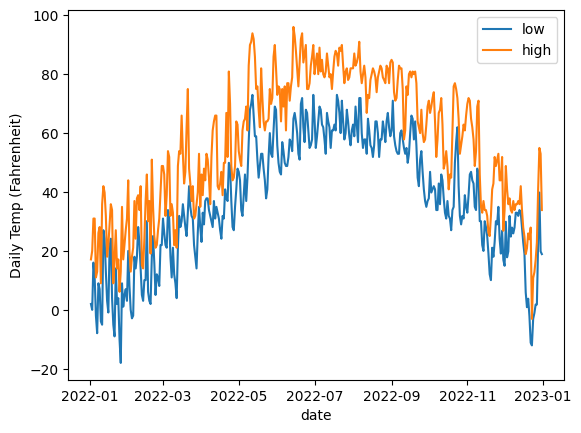

In [17]:
# TODO: Q3
data = spark.sql("""
SELECT id, date, cel_to_far(record.tmin) as min_temp, cel_to_far(record.tmax) as max_temp
FROM weather2022
WHERE id = "USW00014837"
""").toPandas()

data["min_temp"]= data['min_temp'].astype(float) #for plotting
data['max_temp'] = data['max_temp'].astype(float)

fig = data.plot.line(x = "date", y = ["min_temp", "max_temp"], ylabel = "Daily Temp (Fahrenheit)")
fig.legend(["low", "high"])

In [18]:
# TODO: Q4
station1 = spark.sql("""
SELECT id, cel_to_far(record.tmax) as temp_max
FROM weather2022
WHERE id = "USW00014837" 
""").toPandas()

station2 = spark.sql("""
SELECT id, cel_to_far(record.tmax) as temp_max
FROM weather2022
WHERE id = "USW00014839" 
""").toPandas()

combined_maxes = spark.createDataFrame(zip(station1["temp_max"], station2["temp_max"]), ["station1", "station2"])
coor_row = combined_maxes.agg(corr("station1", "station2").alias("corr")).collect()
coor_val = list(coor_row[0])[0]
rounded_coor = round(float(coor_val), 2)
print("Correlation is", rounded_coor)

23/09/05 22:58:24 WARN ChannelPool: [s0|/192.168.80.2:9042]  Error while opening new channel (ConnectionInitException: [s0|connecting...] Protocol initialization request, step 1 (STARTUP {CQL_VERSION=3.0.0, DRIVER_NAME=DataStax Java driver for Apache Cassandra(R), DRIVER_VERSION=4.13.0, CLIENT_ID=c83cb587-5ea5-46a1-8b90-62af50fac197, APPLICATION_NAME=Spark-Cassandra-Connector-local-1693954657898}): failed to send request (com.datastax.oss.driver.shaded.netty.channel.StacklessClosedChannelException))


ValueError: can not infer schema from empty dataset

## Part 4

In [31]:
# TODO: Q5
station_id = "USW00014837"
response = stub.StationMax(station_pb2.StationMaxRequest(station = station_id))
if len(response.error) > 0:
    print("StationMax call for", station_id, "returned error:", response.error)
else:
    print("StationMax returned", response.tmax, "for", station_id)

StationMax call for USW00014837 returned error: Couldn't find max value for station USW00014837


23/09/05 03:37:12 WARN ChannelPool: [s0|p6_db_1/172.31.0.4:9042]  Error while opening new channel (ConnectionInitException: [s0|connecting...] Protocol initialization request, step 1 (STARTUP {CQL_VERSION=3.0.0, DRIVER_NAME=DataStax Java driver for Apache Cassandra(R), DRIVER_VERSION=4.13.0, CLIENT_ID=22aff8ef-0f88-4b19-9624-d705dd2f2960, APPLICATION_NAME=Spark-Cassandra-Connector-local-1693883965024}): failed to send request (com.datastax.oss.driver.shaded.netty.channel.StacklessClosedChannelException))


In [32]:
# TODO: Q6
station_id = "USC00477115"
num_errors = simulate_sensor(station_id)
print("Failed to write data for", num_errors, "date(s) of", station_id)

Failed to write data for 0 date(s) of USC00477115


23/09/05 03:39:16 WARN ChannelPool: [s0|p6_db_1/172.31.0.4:9042]  Error while opening new channel (ConnectionInitException: [s0|connecting...] Protocol initialization request, step 1 (STARTUP {CQL_VERSION=3.0.0, DRIVER_NAME=DataStax Java driver for Apache Cassandra(R), DRIVER_VERSION=4.13.0, CLIENT_ID=22aff8ef-0f88-4b19-9624-d705dd2f2960, APPLICATION_NAME=Spark-Cassandra-Connector-local-1693883965024}): failed to send request (com.datastax.oss.driver.shaded.netty.channel.StacklessClosedChannelException))
23/09/05 03:40:19 WARN ChannelPool: [s0|p6_db_1/172.31.0.4:9042]  Error while opening new channel (ConnectionInitException: [s0|connecting...] Protocol initialization request, step 1 (STARTUP {CQL_VERSION=3.0.0, DRIVER_NAME=DataStax Java driver for Apache Cassandra(R), DRIVER_VERSION=4.13.0, CLIENT_ID=22aff8ef-0f88-4b19-9624-d705dd2f2960, APPLICATION_NAME=Spark-Cassandra-Connector-local-1693883965024}): failed to send request (com.datastax.oss.driver.shaded.netty.channel.StacklessClose

In [33]:
# TODO: Q7
count  = spark.sql("""
SELECT COUNT(record) AS count
FROM weather2022
""").collect()
print("Before refresh:", list(count[0])[0])

spark.sql("REFRESH TABLE weather2022")

count  = spark.sql("""
SELECT COUNT(record) AS count
FROM weather2022
""").collect()
print("After refresh:", list(count[0])[0])

Before refresh: 1460


23/09/05 03:40:39 ERROR CassandraConnectorConf: Unknown host 'p6_db_1'
java.net.UnknownHostException: p6_db_1: Temporary failure in name resolution
	at java.net.Inet4AddressImpl.lookupAllHostAddr(Native Method)
	at java.net.InetAddress$2.lookupAllHostAddr(InetAddress.java:867)
	at java.net.InetAddress.getAddressesFromNameService(InetAddress.java:1302)
	at java.net.InetAddress$NameServiceAddresses.get(InetAddress.java:815)
	at java.net.InetAddress.getAllByName0(InetAddress.java:1291)
	at java.net.InetAddress.getAllByName(InetAddress.java:1144)
	at java.net.InetAddress.getAllByName(InetAddress.java:1065)
	at java.net.InetAddress.getByName(InetAddress.java:1015)
	at com.datastax.spark.connector.cql.CassandraConnectorConf$.maybeResolveHostAndPort(CassandraConnectorConf.scala:346)
	at com.datastax.spark.connector.cql.CassandraConnectorConf$.$anonfun$getIpBasedContactInfoFromSparkConf$1(CassandraConnectorConf.scala:379)
	at scala.collection.TraversableLike.$anonfun$flatMap$1(TraversableLike.

After refresh: 1825


23/09/05 03:40:45 WARN ChannelPool: [s1|/172.31.0.4:9042]  Error while opening new channel (ConnectionInitException: [s1|connecting...] Protocol initialization request, step 1 (STARTUP {CQL_VERSION=3.0.0, DRIVER_NAME=DataStax Java driver for Apache Cassandra(R), DRIVER_VERSION=4.13.0, CLIENT_ID=28dd37f3-7838-42dc-8e14-dc496e4417b5, APPLICATION_NAME=Spark-Cassandra-Connector-local-1693883965024}): failed to send request (com.datastax.oss.driver.shaded.netty.channel.StacklessClosedChannelException))
23/09/05 03:40:48 WARN ChannelPool: [s1|/172.31.0.4:9042]  Error while opening new channel (ConnectionInitException: [s1|connecting...] Protocol initialization request, step 1 (STARTUP {CQL_VERSION=3.0.0, DRIVER_NAME=DataStax Java driver for Apache Cassandra(R), DRIVER_VERSION=4.13.0, CLIENT_ID=28dd37f3-7838-42dc-8e14-dc496e4417b5, APPLICATION_NAME=Spark-Cassandra-Connector-local-1693883965024}): failed to send request (com.datastax.oss.driver.shaded.netty.channel.StacklessClosedChannelExcept

In [ ]:
spark.stop()
session.shutdown()
cluster.shutdown()